In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
import cv2
from keras.preprocessing.image import img_to_array
try:
    from imutils import paths
except ImportError:
    !pip install imutils
    from imutils import paths
    
import matplotlib.pyplot as plt
%matplotlib inline

# dataset download api command
# kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Lets start by analyzing the number of images in each class for the training set

In [3]:
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))
print(len(pneumonia_train))
print(len(normal_train))

7011
6992


### 1. Explanatory Analysis
Let's go into each class and randomly display some images to get an idea of how they look. But first lets make a function to do this for us.

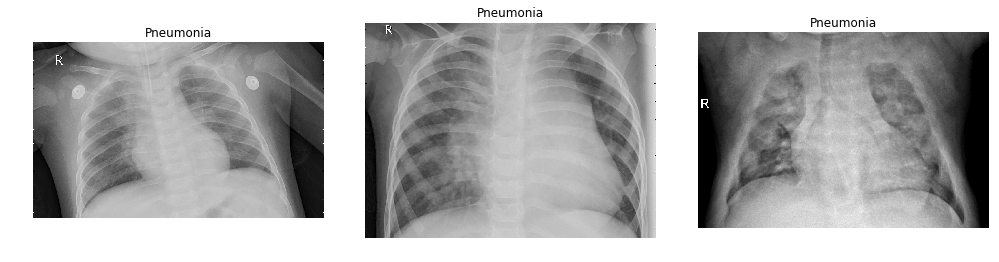

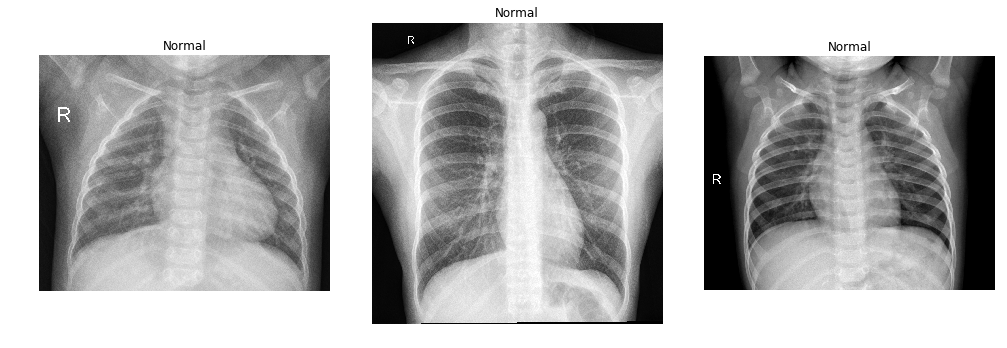

In [4]:
# define classes
columns = 3
classes = {
    "Pneumonia":[cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.sample(pneumonia_train, columns)], 
    "Normal": [cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB) for img in random.sample(normal_train, columns)]
}

# this method displays images for two classes above and below
def display(classes, columns, read_as_rgb=True, cmap=None):
    for _class in classes:
        #print(random_images)
        fig, axes = plt.subplots(nrows=1, ncols=columns, figsize=(14, 10), squeeze=False)
        fig.tight_layout()
        for l in range(1):
            for m, img in enumerate(classes[_class]):
                axes[l][m].imshow(img, cmap=cmap)
                axes[l][m].axis("off")
                axes[l][m].set_title(_class)
    # done displaying
    
# display images
display(classes, columns)

### Image Preprocessing


As we can see from the above images, some have low contrast and for some chest cavity is little blurry. Let us do some preprocessing that will bring up the contrast in the images. The preferred approach for this is to histogram equalize the images in the Value channel of HSV color space. See the below images before and after histogram equalization to see the differnce in the information.

                                        Before Histogram Equalization
![alt text](notebook_images/hist_eq_before.png)
                                        



                                        After Histogram Equalization
![alt text](notebook_images/hist_eq_after.png )
                                 
We can clrealy see how histogram equalization has brought up the contrast in the grayscale image and is much clearer to see. So we will perform histogram equalization as one of the preprocessing steps to our current images.

Let's make a fucntion for the preprocessing of images and display them together to see if we have any improvement after preprocessing.

In [5]:
def preprocess(image, input_mode="grayscale"):
    # convert to uint8 watch out after new definition
    img = image.astype(np.uint8)
    # if the image is of bgr then equalize each channel and join back
    if input_mode == "bgr":
        B, G, R = cv2.split(img)
        B = cv2.equalizeHist(B)
        G = cv2.equalizeHist(G)
        R = cv2.equalizeHist(R)
        img = cv2.merge([B, G, R])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # if grayscale image
    elif input_mode == "grayscale":
        img = cv2.equalizeHist(img)
    return img

From now on we will be converting all the images to grayscale and will do all preprocessing on them as there is not much information in the R,G,B channels.

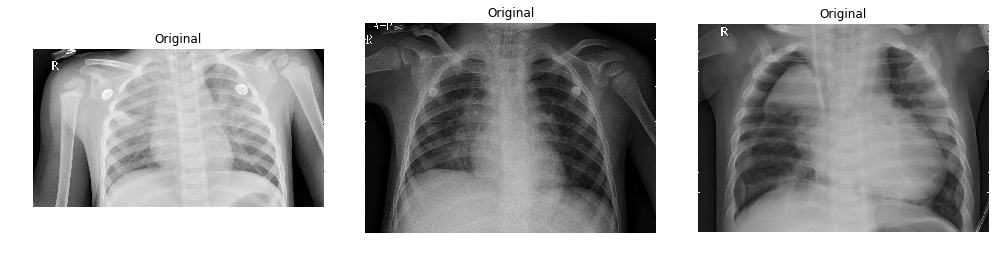

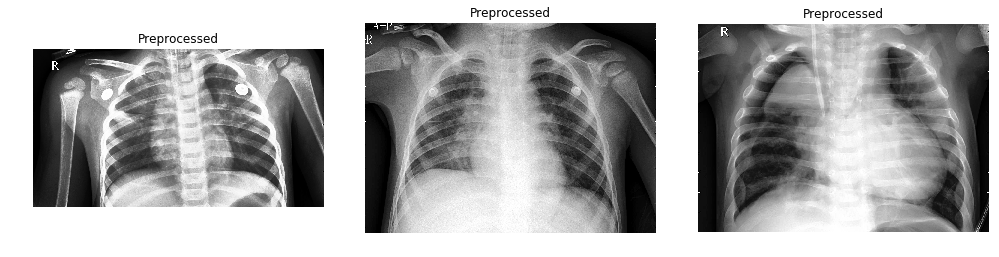

In [7]:
# get some random positive images
sample_positive = random.sample(pneumonia_train, 3)

# make a dictionary regular samples and preprocessed ones
classes = {
    "Original": [cv2.imread(img, 0) for img in sample_positive],
    "Preprocessed": [preprocess(cv2.imread(img, 0), input_mode="grayscale") for img in sample_positive]
} 

# display the images 
display(classes, 3, cmap="gray")

### 2. Data Preprocessing and Augumentation

In this section we will generate and standardize data to address class imbalance problem that we saw above (images of one class are less than each other)

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

IM_WIDTH = 224
IM_HEIGHT = 224
BATCH_SIZE = 32

try:
    from imutils import paths
except ModuleNotFoundError:
    !pip install imutils
    from imutils import paths

_generator = ImageDataGenerator(
    width_shift_range=0.01,
    height_shift_range=0.01,
    zoom_range=0.01,
    horizontal_flip=True,
    rotation_range=2.99,
)

In [9]:
# function loads all the images from a path and returns them as a numpy ndarray
def load_images_from_path(directory):
    image_paths = list(paths.list_images(directory))
    images = []
    for i, im_path in enumerate(image_paths):
        # read 
        image = cv2.imread(im_path, 0)
        # resize
        image = cv2.resize(image, (256, 256))
        # append
        images.append(image)
    _images = [img_to_array(image, data_format="channels_last") for image in images]
    _images = np.array(_images)
    return _images

In [10]:
# we will make 7000 samples of training images for each class
THRESHOLD = 7000
print("Loading images for NORMAL...")
X_normal  = load_images_from_path(directory=os.path.join(os.getcwd(), "chest_xray/train/NORMAL/"))
print("Finished loading images for NORMAL...")
X_normal_aug = _generator.flow(
    x=X_normal,
    y=None,
    batch_size=32,
    save_to_dir="chest_xray/train/NORMAL/",
    save_format="jpeg",
    save_prefix="augumented"
)
for i in range(int(np.ceil((THRESHOLD - X_normal.shape[0])/32))):
    if i % 1000 == 0:
        print("Augumenting {}th image of {}".format(i, THRESHOLD))
    x_normal = next(X_normal_aug)

Loading images for NORMAL...
Finished loading images for NORMAL...
Augumenting 0th image of 7000


In [11]:
# now also augument the Pneumonia class images
print("Loading images for PNEUMONIA...")
X_pneumonia = load_images_from_path(directory=os.path.join(os.getcwd(), "chest_xray/train/PNEUMONIA/"))
print("Finished loading images for PNEUMONIA...")
X_pneumonia_aug = _generator.flow(
    x=X_pneumonia,
    y=None,
    batch_size=32,
    save_to_dir="chest_xray/train/PNEUMONIA/",
    save_format="jpeg",
    save_prefix="augumented"
)
for i in range(int(np.ceil((THRESHOLD - X_pneumonia.shape[0])/32))):
    if i % 1000 == 0:
        print("Augumenting {}th image of {}".format(i, THRESHOLD))
    x_pneumonia = next(X_pneumonia_aug)

Loading images for PNEUMONIA...
Finished loading images for PNEUMONIA...
Augumenting 0th image of 7000


To save GPU time and increase performance of the "fit_generator" function during training, we will read all images from tran,test and validation directories preprocess them ahead of training and write them back. This will save a lot of time and leads to consistent and reproducable results (mostly).

In [12]:
# we will read all images in the train, val, and test prprocess them and save them to disk to 
# avoid slow training time (GPU partial utilization)
pneumonia_train = list(paths.list_images("chest_xray/train/PNEUMONIA/"))
normal_train = list(paths.list_images("chest_xray/train/NORMAL/"))

pneumonia_val = list(paths.list_images("chest_xray/val/PNEUMONIA/"))
normal_val = list(paths.list_images("chest_xray/val/NORMAL/"))

pneumonia_test = list(paths.list_images("chest_xray/test/PNEUMONIA/"))
normal_test = list(paths.list_images("chest_xray/test/NORMAL/"))

# for each directory
for i, directory in enumerate([
    pneumonia_train, normal_train, pneumonia_val, 
    normal_val, pneumonia_test, normal_test
]):
    print("Preprocessing images for {}".format(str(i)))
    # for each image
    for path in directory:
        # read the image
        image = cv2.imread(path, 0)
        image = preprocess(image, input_mode="grayscale")
        image = cv2.resize(image, (IM_HEIGHT, IM_WIDTH))
        cv2.imwrite(path, image)

Preprocessing images for 0
Preprocessing images for 1
Preprocessing images for 2
Preprocessing images for 3
Preprocessing images for 4
Preprocessing images for 5


Define the generators required for Training and Validation 

In [4]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
np.random.seed(255)
import os
os.environ["PYTHONHASHSEED"] = str(255)
import random
random.seed(255)
import tensorflow as tf
tf.set_random_seed(255)

from keras import backend as K
tf_config = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.Session(graph=tf.get_default_graph(), config=tf_config)
K.set_session(sess)

COLOR_MODE = "grayscale"

# generator for train and validation
_image_generator = ImageDataGenerator(
    rescale=1./255
)

# train
_train = _image_generator.flow_from_directory(
    directory="chest_xray/train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="training"
)


# validation
_valid = _image_generator.flow_from_directory(
    directory="chest_xray/val/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=False,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=16
)

# new validation split gives more variety to the validation 
_new_validation = _image_generator.flow_from_directory(
    directory="chest_xray/train/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=True,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    subset="validation"
)

Found 14003 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 0 images belonging to 2 classes.


### Model Definition and Training

Let us construct a CNN and train with above data

In [5]:
from keras import callbacks
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, LearningRateScheduler

In [34]:
class CustomNet(object):

    def __init__(self, height, width, channels, classes, parameter_scaling):
        self.height = height
        self.width = width
        self.channels = channels
        self.output_classes = classes
        self.scale = parameter_scaling
    
    def model(self):
        input_shape = (self.height, self.width, self.channels)
        chan_dim = -1
        # initiate model
        model = Sequential()
        
        # 224x224
        # conv 1
        model.add(Conv2D(self.scale, (3, 3), padding="same", input_shape=input_shape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 2
        model.add(Conv2D(self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 1
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.1))
        
        # 112x112
        # conv 3
        model.add(Conv2D(2*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 4
        model.add(Conv2D(2*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 2
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.2))
        
        # 56x56
        # conv 5
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 6
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # conv 7
        model.add(Conv2D(3*self.scale, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        # pool 3
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.5))

        # fully connected 
        model.add(Flatten())
        # fc 1
        model.add(Dense(512))
        model.add(Activation("relu"))
        #model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        # fc 2
        model.add(Dense(1024))
        model.add(Activation("relu"))
        #model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(self.output_classes, activation="softmax"))
        
        # print(model.summary())
        # return 
        return model

In [37]:
LR = 1e-4
SCALE = 10
BATCH_SIZE = 64
EPOCHS = 25

def lr_scheduler(epoch, lr):
    if epoch >= 16:
        return (1e-4)*0.25
    else:
        return lr
    
# define callbacks
_callbacks = [
    callbacks.TensorBoard(
        log_dir="tensorboard",
        write_graph=True,
        write_images=False    
    ),
    LearningRateScheduler(lr_scheduler)
]

# initiate model
model = CustomNet(
    height=IM_HEIGHT, 
    width=IM_WIDTH, 
    channels=1, 
    classes=2, 
    parameter_scaling=SCALE
).model()

# compile
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(lr=LR),
    metrics=["accuracy"]
)

In [38]:
# start training
history = model.fit_generator(
    generator=_train,
    steps_per_epoch=_train.samples//BATCH_SIZE,
    validation_data=_valid,
    validation_steps=_valid.samples,
    callbacks=_callbacks,
    epochs=EPOCHS
)

Epoch 1/25
218/218 [==============================] - 38s 173ms/step - loss: 0.5377 - acc: 0.8369 - val_loss: 0.2742 - val_acc: 0.9375
Epoch 2/25
218/218 [==============================] - 35s 160ms/step - loss: 0.2015 - acc: 0.9282 - val_loss: 0.2847 - val_acc: 0.9375
Epoch 3/25
218/218 [==============================] - 35s 160ms/step - loss: 0.1461 - acc: 0.9445 - val_loss: 0.2465 - val_acc: 0.8750
Epoch 4/25
218/218 [==============================] - 35s 160ms/step - loss: 0.1314 - acc: 0.9507 - val_loss: 0.2806 - val_acc: 0.9375
Epoch 5/25
218/218 [==============================] - 35s 160ms/step - loss: 0.1214 - acc: 0.9573 - val_loss: 0.1525 - val_acc: 0.9375
Epoch 6/25
218/218 [==============================] - 35s 160ms/step - loss: 0.1047 - acc: 0.9626 - val_loss: 0.2579 - val_acc: 0.8750
Epoch 7/25
218/218 [==============================] - 35s 160ms/step - loss: 0.0981 - acc: 0.9649 - val_loss: 0.2372 - val_acc: 0.9375
Epoch 8/25
218/218 [==============================] - 3

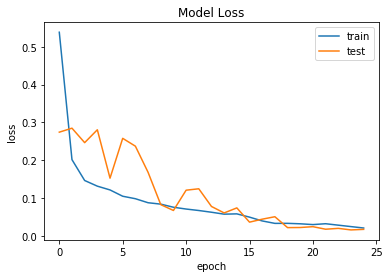

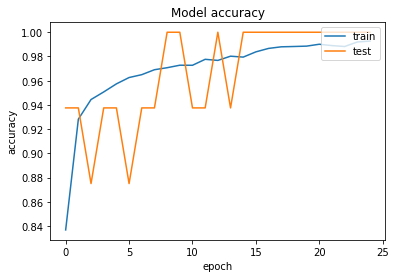

In [39]:
# PLOTTING
import matplotlib.pyplot as plt
%matplotlib inline

# plot the loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# plot the accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [40]:
# test data
# validation
_test = _image_generator.flow_from_directory(
    directory="chest_xray/test/",
    target_size=(IM_WIDTH, IM_HEIGHT),
    shuffle=False,
    seed=255,
    color_mode=COLOR_MODE,
    class_mode="categorical",
    batch_size=1
)
print(_test.class_indices)

Found 624 images belonging to 2 classes.
{'NORMAL': 0, 'PNEUMONIA': 1}


In [41]:
test_loss, test_acc = model.evaluate_generator(_test, steps=_test.samples)

print('val_loss:', test_loss)
print('val_cat_acc:', test_acc)

val_loss: 1.6218867755658555
val_cat_acc: 0.7996794871794872


In [42]:
# PREDICT
predictions = model.predict_generator(_test, steps=_test.samples, verbose=1)
print(predictions.shape)
y_pred = np.argmax(predictions, axis=1)
y_test = _test.classes

624/624 [==============================] - 5s 8ms/step
(624, 2)


In [43]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

report = classification_report(y_test, y_pred, target_names=['NORMAL', 'PNEUMONIA'])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.92      0.44      0.60       234
   PNEUMONIA       0.75      0.98      0.85       390

   micro avg       0.78      0.78      0.78       624
   macro avg       0.83      0.71      0.72       624
weighted avg       0.81      0.78      0.75       624



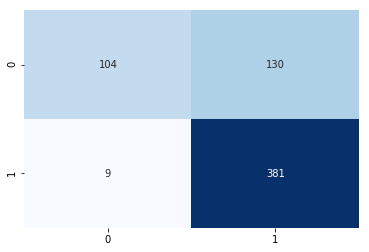

In [44]:
# heatmap
sns.heatmap(
    confusion_matrix(y_test, y_pred), 
    annot=True, 
    fmt="d", 
    cbar = False, 
    cmap = plt.cm.Blues
)

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# accuracy score
print("Accuracy score of the model: {:.2f}".format(accuracy_score(y_test, y_pred)))

# f1 score
print("F1 score of the model: {:.2f}".format(f1_score(y_test, y_pred)))

# precision
print("Precision score of the model: {:.2f}".format(precision_score(y_test, y_pred)))

# recall
print("Recall score of the model: {:.2f}".format(recall_score(y_test, y_pred)))

Accuracy score of the model: 0.78
F1 score of the model: 0.85
Precision score of the model: 0.75
Recall score of the model: 0.98


## References

- https://towardsdatascience.com/histogram-equalization-5d1013626e64
- https://hypjudy.github.io/2017/03/19/dip-histogram-equalization/